In [1]:
from astropy.io import fits
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pyarrow.parquet as parquet
import fast_histogram as fh
import time
import dask.dataframe as dd


/home/bekah/mambaforge/envs/gphoton2/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
def dosemap_ranges(radius):
    slop = 400 - radius
    return [slop, 3200 - slop], [slop, 3200 - slop]

In [3]:
# load data for being on detector / in dosemap frame, convert to dosemap coords

nf = parquet.read_table("/home/bekah/gPhoton2/test_data/e23456/e23456-nd-b00.parquet",
                       columns=['col', 'row', 'ra', 'dec', 'response']).to_pandas()

#nf = parquet.read_table("/home/bekah/gPhoton2/test_data/e23456/e00929-fd-b00.parquet",
#                        columns=['col', 'row', 'ra', 'dec', 'response']).to_pandas()

In [4]:
bstart = time.time()


In [5]:
### FILTERING ARRAY ### 
start_time = time.time()

print("filtering data")

# this is an antiquated cutoff from when radius was 600 for 2dhist
nf = nf[(nf['row']*4 >= -200) & (nf['row']*4 <= 3400) & (nf['col']*4 >= -200) & (nf['col']*4 <= 3400)]

nf['row_rnd'] = nf['row'].round().astype(int)
nf['col_rnd'] = nf['col'].round().astype(int)

nf = nf[(nf['row_rnd'] <= 4799) & (nf['col_rnd'] <= 4799) & (nf['ra']!= 0) & (nf['dec']!= 0)]

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

filtering data
it took 3.0458 seconds


In [6]:
### COUNT HIST ### 
start_time = time.time()

print("finished filtering data, making histogram now")
# make 2d histogram and filter for dark and hotpsots. "hotspots" will inevitably contain bright stars

hist = fh.histogram2d(
       nf['col'], nf['row'],bins=800, range=([0,800],[0,800])).astype('float32')

print("done with histogram")

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

finished filtering data, making histogram now
done with histogram
it took 0.2993 seconds


In [7]:
### CALCULATING DISPERSION & RESPONSE ### 
start_time = time.time()

print("calculating dispersion & mean response")

dispersion = nf.groupby(['col_rnd', 'row_rnd']).agg({
    'ra': 'std',
    'dec': 'std',
    'response': 'mean'
}).reset_index()

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

calculating dispersion & mean response
it took 7.1456 seconds


In [8]:
### DISP ARRAY ### 

start_time = time.time()

# making np array of dispersion ra / dec 
print("making dispersion array")

dispersion = dispersion[(dispersion['col_rnd']<800)&(dispersion['row_rnd']<800)]
max_col = dispersion['col_rnd'].max()
max_row = dispersion['row_rnd'].max()

ra_dec_disp = np.zeros((800, 800))

ra_dec_disp[dispersion['col_rnd'], dispersion['row_rnd']] = abs(dispersion['ra'])+abs(dispersion['dec'])

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

making dispersion array
it took 0.0226 seconds


In [9]:
### RESPONSE ARRAY ### 

start_time = time.time()

# making np array of response
print("making response array")

dispersion = dispersion[(dispersion['col_rnd']<800)&(dispersion['row_rnd']<800)]
#max_col = dispersion['col_rnd'].max()
#max_row = dispersion['row_rnd'].max()

response_map = np.zeros((800, 800))

response_map[dispersion['col_rnd'], dispersion['row_rnd']] = dispersion['response']

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

making response array
it took 0.0192 seconds


In [10]:
### MASKING ### 

start_time = time.time()
print("masking")

# density mask
density_mask = hist > 400 # not doing low density bc we have response, otherwise gets mixed with background

# dispersion mask
disp_mask = ra_dec_disp > .014

# response map 
response_mask = response_map < .7 

# combo mask
result_array = np.zeros(hist.shape, dtype=int)+1

result_array[density_mask & disp_mask] = 0
result_array[response_mask] = 0

# saving mask to fits 
hdu = fits.PrimaryHDU(result_array)
hdul = fits.HDUList([hdu])
hdul.writeto('mask.fits', overwrite=True)

end_time = time.time()

duration = end_time - start_time
print(f"it took {duration:.4f} seconds")

masking
it took 0.0288 seconds


In [11]:
bend = time.time()

print(f"total time: {bstart-bend}")

total time: -10.61858320236206


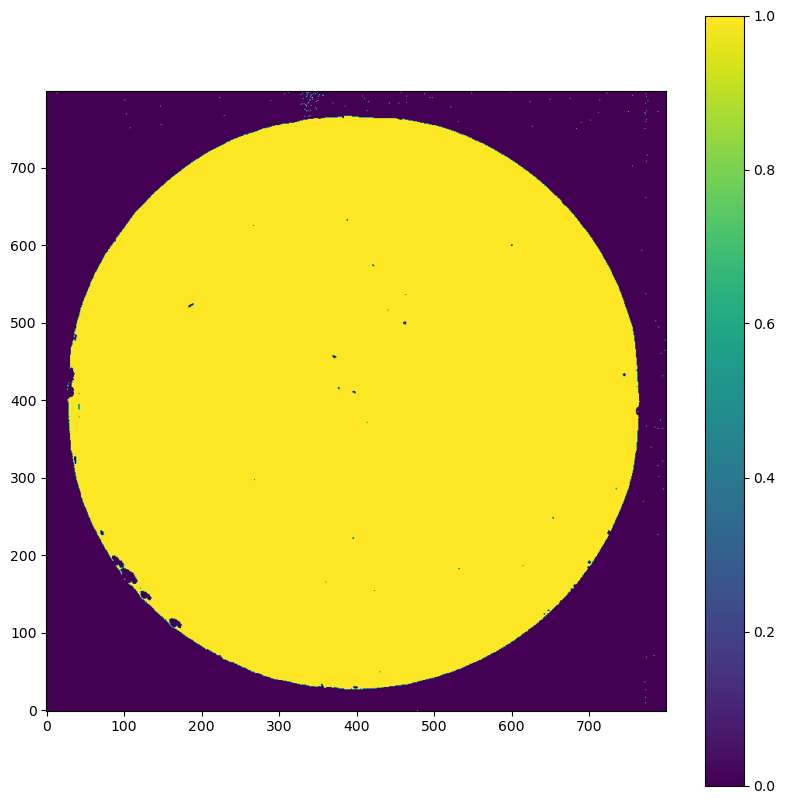

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(result_array, interpolation=None,origin='lower')
plt.colorbar()
